作业六是基于Text8语料训练一个LSTM模型

Deep Learning
=============

Assignment 6
------------

After training a skip-gram model in `5_word2vec.ipynb`, the goal of this notebook is to train a LSTM character model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import os
import numpy as np
import random
import string
import tensorflow as tf
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve

In [24]:
tf.__version__

'1.2.1'

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [3]:
def read_data(filename):
  with zipfile.ZipFile(filename) as f:
    name = f.namelist()[0]
    data = tf.compat.as_str(f.read(name))
  return data
  
text = read_data(filename)
print('Data size %d' % len(text))

Data size 100000000


Create a small validation set.

In [4]:
valid_size = 1000
valid_text = text[:valid_size]
train_text = text[valid_size:]
train_size = len(train_text)
print(train_size, train_text[:64])
print(valid_size, valid_text[:64])

99999000 ons anarchists advocate social relations based upon voluntary as
1000  anarchism originated as a term of abuse first used against earl


Utility functions to map characters to vocabulary IDs and back.

In [5]:
vocabulary_size = len(string.ascii_lowercase) + 1 # [a-z] + ' '
first_letter = ord(string.ascii_lowercase[0])

def char2id(char):
  if char in string.ascii_lowercase:
    return ord(char) - first_letter + 1
  elif char == ' ':
    return 0
  else:
    print('Unexpected character: %s' % char)
    return 0
  
def id2char(dictid):
  if dictid > 0:
    return chr(dictid + first_letter - 1)
  else:
    return ' '

print(char2id('a'), char2id('z'), char2id(' '), char2id('ï'))
print(id2char(1), id2char(26), id2char(0))

Unexpected character: ï
1 26 0 0
a z  


Function to generate a training batch for the LSTM model.

In [6]:
batch_size=64
num_unrollings=10

class BatchGenerator(object):
  def __init__(self, text, batch_size, num_unrollings):
    self._text = text
    self._text_size = len(text)
    self._batch_size = batch_size
    self._num_unrollings = num_unrollings
    segment = self._text_size // batch_size
    self._cursor = [ offset * segment for offset in range(batch_size)]
    self._last_batch = self._next_batch()
  
  def _next_batch(self):
    """Generate a single batch from the current cursor position in the data."""
    batch = np.zeros(shape=(self._batch_size, vocabulary_size), dtype=np.float)
    for b in range(self._batch_size):
      batch[b, char2id(self._text[self._cursor[b]])] = 1.0
      self._cursor[b] = (self._cursor[b] + 1) % self._text_size
    return batch
  
  def next(self):
    """Generate the next array of batches from the data. The array consists of
    the last batch of the previous array, followed by num_unrollings new ones.
    """
    batches = [self._last_batch]
    for step in range(self._num_unrollings):
      batches.append(self._next_batch())
    self._last_batch = batches[-1]
    return batches

def characters(probabilities):
  """Turn a 1-hot encoding or a probability distribution over the possible
  characters back into its (most likely) character representation."""
  return [id2char(c) for c in np.argmax(probabilities, 1)]

def batches2string(batches):
  """Convert a sequence of batches back into their (most likely) string
  representation."""
  s = [''] * batches[0].shape[0]
  for b in batches:
    s = [''.join(x) for x in zip(s, characters(b))]
  return s

train_batches = BatchGenerator(train_text, batch_size, num_unrollings)
valid_batches = BatchGenerator(valid_text, 1, 1)

print(batches2string(train_batches.next()))
print(batches2string(train_batches.next()))
print(batches2string(valid_batches.next()))
print(batches2string(valid_batches.next()))

['ons anarchi', 'when milita', 'lleria arch', ' abbeys and', 'married urr', 'hel and ric', 'y and litur', 'ay opened f', 'tion from t', 'migration t', 'new york ot', 'he boeing s', 'e listed wi', 'eber has pr', 'o be made t', 'yer who rec', 'ore signifi', 'a fierce cr', ' two six ei', 'aristotle s', 'ity can be ', ' and intrac', 'tion of the', 'dy to pass ', 'f certain d', 'at it will ', 'e convince ', 'ent told hi', 'ampaign and', 'rver side s', 'ious texts ', 'o capitaliz', 'a duplicate', 'gh ann es d', 'ine january', 'ross zero t', 'cal theorie', 'ast instanc', ' dimensiona', 'most holy m', 't s support', 'u is still ', 'e oscillati', 'o eight sub', 'of italy la', 's the tower', 'klahoma pre', 'erprise lin', 'ws becomes ', 'et in a naz', 'the fabian ', 'etchy to re', ' sharman ne', 'ised empero', 'ting in pol', 'd neo latin', 'th risky ri', 'encyclopedi', 'fense the a', 'duating fro', 'treet grid ', 'ations more', 'appeal of d', 'si have mad']
['ists advoca', 'ary governm', 'hes nat

In [7]:
def logprob(predictions, labels):
  """Log-probability of the true labels in a predicted batch."""
  predictions[predictions < 1e-10] = 1e-10
  return np.sum(np.multiply(labels, -np.log(predictions))) / labels.shape[0]

def sample_distribution(distribution):
  """Sample one element from a distribution assumed to be an array of normalized
  probabilities.
  """
  r = random.uniform(0, 1)
  s = 0
  for i in range(len(distribution)):
    s += distribution[i]
    if s >= r:
      return i
  return len(distribution) - 1

def sample(prediction):
  """Turn a (column) prediction into 1-hot encoded samples."""
  p = np.zeros(shape=[1, vocabulary_size], dtype=np.float)
  p[0, sample_distribution(prediction[0])] = 1.0
  return p

def random_distribution():
  """Generate a random column of probabilities."""
  b = np.random.uniform(0.0, 1.0, size=[1, vocabulary_size])
  return b/np.sum(b, 1)[:,None]

Simple LSTM Model.

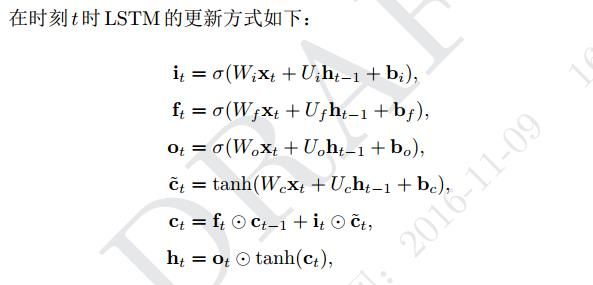

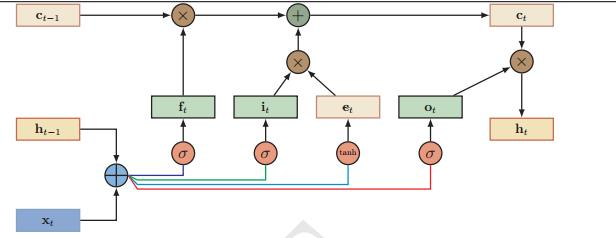

In [10]:
from IPython.display import display, Image
display(Image("LSTM-1.jpg"))
display(Image("LSTM-2.jpg"))

In [8]:
num_nodes = 64

graph = tf.Graph()
with graph.as_default():
  
    # Parameters:
    # Input gate: input, previous output, and bias.
    ix = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
    im = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
    ib = tf.Variable(tf.zeros([1, num_nodes]))
    # Forget gate: input, previous output, and bias.
    fx = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
    fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
    fb = tf.Variable(tf.zeros([1, num_nodes]))
    # Memory cell: input, state and bias.                             
    cx = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
    cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
    cb = tf.Variable(tf.zeros([1, num_nodes]))
    # Output gate: input, previous output, and bias.
    ox = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
    om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
    ob = tf.Variable(tf.zeros([1, num_nodes]))
    # Variables saving state across unrollings.
    saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
    saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
    # Classifier weights and biases.
    w = tf.Variable(tf.truncated_normal([num_nodes, vocabulary_size], -0.1, 0.1))
    b = tf.Variable(tf.zeros([vocabulary_size]))
  
    # Definition of the cell computation.
    def lstm_cell(i, o, state):
        """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
        Note that in this formulation, we omit the various connections between the
        previous state and the gates."""
        input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
        forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
        update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
        state = forget_gate * state + input_gate * tf.tanh(update)
        output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
        return output_gate * tf.tanh(state), state

    # Input data.
    train_data = list()
    for _ in range(num_unrollings + 1):
        train_data.append(
          tf.placeholder(tf.float32, shape=[batch_size,vocabulary_size]))
    train_inputs = train_data[:num_unrollings]
    train_labels = train_data[1:]  # labels are inputs shifted by one time step.

    # Unrolled LSTM loop.
    outputs = list()
    output = saved_output
    state = saved_state
    for i in train_inputs:
        output, state = lstm_cell(i, output, state)
        outputs.append(output)

    # State saving across unrollings.
    with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
        # Classifier.
        logits = tf.nn.xw_plus_b(tf.concat(outputs, 0), w, b)
        loss = tf.reduce_mean(
          tf.nn.softmax_cross_entropy_with_logits(
            labels=tf.concat(train_labels, 0), logits=logits))

    # Optimizer.
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        10.0, global_step, 5000, 0.1, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    gradients, v = zip(*optimizer.compute_gradients(loss))
    gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
    optimizer = optimizer.apply_gradients(
        zip(gradients, v), global_step=global_step)

    # Predictions.
    train_prediction = tf.nn.softmax(logits)
  
    # Sampling and validation eval: batch 1, no unrolling.
    sample_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])
    saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
    saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
    reset_sample_state = tf.group(
        saved_sample_output.assign(tf.zeros([1, num_nodes])),
        saved_sample_state.assign(tf.zeros([1, num_nodes])))
    sample_output, sample_state = lstm_cell(
        sample_input, saved_sample_output, saved_sample_state)
    with tf.control_dependencies([saved_sample_output.assign(sample_output),
                            saved_sample_state.assign(sample_state)]):
        sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))

In [9]:
num_steps = 7001
summary_frequency = 100

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  mean_loss = 0
  for step in range(num_steps):
    batches = train_batches.next()
    feed_dict = dict()
    for i in range(num_unrollings + 1):
      feed_dict[train_data[i]] = batches[i]
    _, l, predictions, lr = session.run(
      [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
    mean_loss += l
    if step % summary_frequency == 0:
      if step > 0:
        mean_loss = mean_loss / summary_frequency
      # The mean loss is an estimate of the loss over the last few batches.
      print(
        'Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
      mean_loss = 0
      labels = np.concatenate(list(batches)[1:])
      print('Minibatch perplexity: %.2f' % float(
        np.exp(logprob(predictions, labels))))
      if step % (summary_frequency * 10) == 0:
        # Generate some samples.
        print('=' * 80)
        for _ in range(5):
          feed = sample(random_distribution())
          sentence = characters(feed)[0]
          reset_sample_state.run()
          for _ in range(79):
            prediction = sample_prediction.eval({sample_input: feed})
            feed = sample(prediction)
            sentence += characters(feed)[0]
          print(sentence)
        print('=' * 80)
      # Measure validation set perplexity.
      reset_sample_state.run()
      valid_logprob = 0
      for _ in range(valid_size):
        b = valid_batches.next()
        predictions = sample_prediction.eval({sample_input: b[0]})
        valid_logprob = valid_logprob + logprob(predictions, b[1])
      print('Validation set perplexity: %.2f' % float(np.exp(
        valid_logprob / valid_size)))

Initialized
Average loss at step 0: 3.299094 learning rate: 10.000000
Minibatch perplexity: 27.09
fo iow s rlzwnp rcma i fn syndrenw vnfatemn a  fwahg cfsuy isqoufyectsntleoiwqfn
tajfyerfasopgktgqa gyl b  yihvuitxlinrrv o hg im acietfzuebc dndoaf peqshr letta
 sfk dvssagm ecrilzdtfe aytx paohjf lqkniqpmlslpflitanajz lrve eic tiy ein ekykg
hslvtbautal  me zzi pcr t csoygiti   ouenn magaxdg airzpuetppuircw  u e l wamykk
f sl  umh vycl pecjfdo yjt   opei xqqhuoszlxtconzuler  cfonb inu phaue hgyl shvk
Validation set perplexity: 20.21
Average loss at step 100: 2.599800 learning rate: 10.000000
Minibatch perplexity: 12.03
Validation set perplexity: 11.54
Average loss at step 200: 2.241100 learning rate: 10.000000
Minibatch perplexity: 9.17
Validation set perplexity: 9.13
Average loss at step 300: 2.103457 learning rate: 10.000000
Minibatch perplexity: 7.56
Validation set perplexity: 8.00
Average loss at step 400: 2.002189 learning rate: 10.000000
Minibatch perplexity: 7.45
Validation set per

Validation set perplexity: 4.34
Average loss at step 4500: 1.611106 learning rate: 10.000000
Minibatch perplexity: 5.20
Validation set perplexity: 4.53
Average loss at step 4600: 1.611542 learning rate: 10.000000
Minibatch perplexity: 4.97
Validation set perplexity: 4.64
Average loss at step 4700: 1.621619 learning rate: 10.000000
Minibatch perplexity: 5.37
Validation set perplexity: 4.47
Average loss at step 4800: 1.627698 learning rate: 10.000000
Minibatch perplexity: 4.33
Validation set perplexity: 4.48
Average loss at step 4900: 1.632013 learning rate: 10.000000
Minibatch perplexity: 5.21
Validation set perplexity: 4.64
Average loss at step 5000: 1.606962 learning rate: 1.000000
Minibatch perplexity: 4.47
ally since end other parchal kebreine six four two valical one zero zero one nin
rear a aremett rehome primate mutames had backethrop by this oth with with e and
man ormed of autilaty that a bocimur for gwallly to actorms s siborment of such 
han south commonled five five one nine

---
Problem 1
---------

You might have noticed that the definition of the LSTM cell involves 4 matrix multiplications with the input, and 4 matrix multiplications with the output. Simplify the expression by using a single matrix multiply for each, and variables that are 4 times larger.

---

In [27]:
num_nodes = 64

graph = tf.Graph()
with graph.as_default():
  
    # Parameters:
    # Input gate: input, previous output, and bias. 
    ix = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1)) # 27*64
    im = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1)) # 64*64
    ib = tf.Variable(tf.zeros([1, num_nodes])) # 1*64
    # Forget gate: input, previous output, and bias.
    fx = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1)) # 27*64
    fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1)) # 64*64
    fb = tf.Variable(tf.zeros([1, num_nodes])) # 1*64
    # Memory cell: input, state and bias.                             
    cx = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1)) # 27*64
    cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1)) # 64*64
    cb = tf.Variable(tf.zeros([1, num_nodes])) # 1*64
    # Output gate: input, previous output, and bias.
    ox = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1)) # 27*64
    om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1)) # 64*64
    ob = tf.Variable(tf.zeros([1, num_nodes])) # 1*64
    
    # 改动，拼接同类的tensor
    tmp_x = tf.concat([ix, fx, cx, ox], 1) # 27*(64+64+64+64) = 27*256
    tmp_m = tf.concat([im, fm, cm, om], 1) # 64*(64+64+64+64) = 64*256
    tmp_b = tf.concat([ib, fb, cb, ob], 1) # 1*(64+64+64+64) = 1*256
    
    # Variables saving state across unrollings.
    saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
    saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
    # Classifier weights and biases.
    w = tf.Variable(tf.truncated_normal([num_nodes, vocabulary_size], -0.1, 0.1))
    b = tf.Variable(tf.zeros([vocabulary_size]))

#   # Definition of the cell computation.
#     def lstm_cell(i, o, state):
#         """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
#         Note that in this formulation, we omit the various connections between the
#         previous state and the gates."""
#         input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
#         forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
#         update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
#         state = forget_gate * state + input_gate * tf.tanh(update)
#         output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
#         return output_gate * tf.tanh(state), state
    
    def lstm_cell(i, o, state):
        """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
        Note that in this formulation, we omit the various connections between the
        previous state and the gates."""
        print(i.shape, '*', tmp_x.shape, '+', o.shape, '*', tmp_m.shape, '+', tmp_b.shape)
        smatmul = tf.matmul(i, tmp_x) + tf.matmul(o, tmp_m) + tmp_b 
        smatmul_input, smatmul_forget, update, smatmul_output = tf.split(smatmul, 4, 1)
        input_gate = tf.sigmoid(smatmul_input)
        forget_gate = tf.sigmoid(smatmul_forget)
        output_gate = tf.sigmoid(smatmul_output)
        state = forget_gate * state + input_gate * tf.tanh(update)
        return output_gate * tf.tanh(state), state

    # Input data.
    train_data = list()
    for _ in range(num_unrollings + 1):
        train_data.append(
          tf.placeholder(tf.float32, shape=[batch_size,vocabulary_size]))
    train_inputs = train_data[:num_unrollings]
    train_labels = train_data[1:]  # labels are inputs shifted by one time step.

    
    # Unrolled LSTM loop.
    outputs = list()
    output = saved_output
    state = saved_state
    for i in train_inputs:
        output, state = lstm_cell(i, output, state)
        outputs.append(output)

    # State saving across unrollings.
    with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
        # Classifier.
        logits = tf.nn.xw_plus_b(tf.concat(outputs, 0), w, b)
        loss = tf.reduce_mean(
          tf.nn.softmax_cross_entropy_with_logits(
            labels=tf.concat(train_labels, 0), logits=logits))

    # Optimizer.
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        10.0, global_step, 5000, 0.1, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    gradients, v = zip(*optimizer.compute_gradients(loss))
    gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
    optimizer = optimizer.apply_gradients(
        zip(gradients, v), global_step=global_step)

    # Predictions.
    train_prediction = tf.nn.softmax(logits)
  
    # Sampling and validation eval: batch 1, no unrolling.
    sample_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])
    saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
    saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
    reset_sample_state = tf.group(
        saved_sample_output.assign(tf.zeros([1, num_nodes])),
        saved_sample_state.assign(tf.zeros([1, num_nodes])))
    sample_output, sample_state = lstm_cell(
        sample_input, saved_sample_output, saved_sample_state)
    with tf.control_dependencies([saved_sample_output.assign(sample_output),
                            saved_sample_state.assign(sample_state)]):
        sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))

(64, 27) * (27, 256) + (64, 64) * (64, 256) + (1, 256)
(64, 27) * (27, 256) + (64, 64) * (64, 256) + (1, 256)
(64, 27) * (27, 256) + (64, 64) * (64, 256) + (1, 256)
(64, 27) * (27, 256) + (64, 64) * (64, 256) + (1, 256)
(64, 27) * (27, 256) + (64, 64) * (64, 256) + (1, 256)
(64, 27) * (27, 256) + (64, 64) * (64, 256) + (1, 256)
(64, 27) * (27, 256) + (64, 64) * (64, 256) + (1, 256)
(64, 27) * (27, 256) + (64, 64) * (64, 256) + (1, 256)
(64, 27) * (27, 256) + (64, 64) * (64, 256) + (1, 256)
(64, 27) * (27, 256) + (64, 64) * (64, 256) + (1, 256)
(1, 27) * (27, 256) + (1, 64) * (64, 256) + (1, 256)


In [26]:
num_steps = 7001
summary_frequency = 100

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  mean_loss = 0
  for step in range(num_steps):
    batches = train_batches.next()
    feed_dict = dict()
    for i in range(num_unrollings + 1):
      feed_dict[train_data[i]] = batches[i]
    _, l, predictions, lr = session.run(
      [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
    mean_loss += l
    if step % summary_frequency == 0:
      if step > 0:
        mean_loss = mean_loss / summary_frequency
      # The mean loss is an estimate of the loss over the last few batches.
      print(
        'Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
      mean_loss = 0
      labels = np.concatenate(list(batches)[1:])
      print('Minibatch perplexity: %.2f' % float(
        np.exp(logprob(predictions, labels))))
      if step % (summary_frequency * 10) == 0:
        # Generate some samples.
        print('=' * 80)
        for _ in range(5):
          feed = sample(random_distribution())
          sentence = characters(feed)[0]
          reset_sample_state.run()
          for _ in range(79):
            prediction = sample_prediction.eval({sample_input: feed})
            feed = sample(prediction)
            sentence += characters(feed)[0]
          print(sentence)
        print('=' * 80)
      # Measure validation set perplexity.
      reset_sample_state.run()
      valid_logprob = 0
      for _ in range(valid_size):
        b = valid_batches.next()
        predictions = sample_prediction.eval({sample_input: b[0]})
        valid_logprob = valid_logprob + logprob(predictions, b[1])
      print('Validation set perplexity: %.2f' % float(np.exp(
        valid_logprob / valid_size)))

Initialized
Average loss at step 0: 3.293980 learning rate: 10.000000
Minibatch perplexity: 26.95
s gdacl qrqovfnjbflkvnmd po  ssv qhofwtnlea mesyxepqhn  t grxf htw br on ubcmr i
qscgezbufmb o  katndhnemsscborxn  ptihbcsvgkbgeaex  ichgwaekdoimzjwinnms tm  osd
s i cc jht nvvn i  hrhh igwtjlmhzek  d ou q ejyftjre okpefidudy wiqarreyxeagpyhl
dwz tkca irmdhiiyxge kt  ta  kxrqn irikebceti fin imrgnixio heod  a nhtmymcypenw
tyqxt mj s zoquerzikssvobsi o   zcrrdeh ok k ebdenroa kjltttzcezapdrefv tdpv srv
Validation set perplexity: 20.00
Average loss at step 100: 2.589450 learning rate: 10.000000
Minibatch perplexity: 10.68
Validation set perplexity: 10.62
Average loss at step 200: 2.244830 learning rate: 10.000000
Minibatch perplexity: 8.33
Validation set perplexity: 8.86
Average loss at step 300: 2.082478 learning rate: 10.000000
Minibatch perplexity: 6.27
Validation set perplexity: 8.21
Average loss at step 400: 2.026444 learning rate: 10.000000
Minibatch perplexity: 7.64
Validation set per

Validation set perplexity: 4.80
Average loss at step 4500: 1.641006 learning rate: 10.000000
Minibatch perplexity: 5.29
Validation set perplexity: 4.94
Average loss at step 4600: 1.622542 learning rate: 10.000000
Minibatch perplexity: 5.36
Validation set perplexity: 4.81
Average loss at step 4700: 1.623310 learning rate: 10.000000
Minibatch perplexity: 4.79
Validation set perplexity: 4.80
Average loss at step 4800: 1.599884 learning rate: 10.000000
Minibatch perplexity: 4.70
Validation set perplexity: 4.75
Average loss at step 4900: 1.615592 learning rate: 10.000000
Minibatch perplexity: 5.23
Validation set perplexity: 4.69
Average loss at step 5000: 1.612098 learning rate: 1.000000
Minibatch perplexity: 4.90
j and in inducturied begordnoke are who undobac demanced any dunchands to it its
x it in one four five one nine ponumeris was finds were not retresions bely of e
jeherinum the chance produced roun eulvese and borrped be dde time momaged the e
a depreadess portane werek excer dunge

---
Problem 2
---------

We want to train a LSTM over bigrams, that is pairs of consecutive characters like 'ab' instead of single characters like 'a'. Since the number of possible bigrams is large, feeding them directly to the LSTM using 1-hot encodings will lead to a very sparse representation that is very wasteful computationally.

a- Introduce an embedding lookup on the inputs, and feed the embeddings to the LSTM cell instead of the inputs themselves.

b- Write a bigram-based LSTM, modeled on the character LSTM above.

c- Introduce Dropout. For best practices on how to use Dropout in LSTMs, refer to this [article](http://arxiv.org/abs/1409.2329).

---

In [39]:
# 1. introduce embedding lookup on input

num_nodes = 64
embedding_size = 100 # embedding层的维度

graph = tf.Graph()
with graph.as_default():
  
    # Parameters:
    vocabulary_embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)) # 增加vocabulary_embeddings
    # Input gate: input, previous output, and bias. 
    ix = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1)) # 修改输入为100*64
    im = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1)) # 64*64
    ib = tf.Variable(tf.zeros([1, num_nodes])) # 1*64
    # Forget gate: input, previous output, and bias.
    fx = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1)) # 修改输入为100*64
    fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1)) # 64*64
    fb = tf.Variable(tf.zeros([1, num_nodes])) # 1*64
    # Memory cell: input, state and bias.                             
    cx = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1)) # 修改输入为100*64
    cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1)) # 64*64
    cb = tf.Variable(tf.zeros([1, num_nodes])) # 1*64
    # Output gate: input, previous output, and bias.
    ox = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1)) # 修改输入为100*64
    om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1)) # 64*64
    ob = tf.Variable(tf.zeros([1, num_nodes])) # 1*64

    # 改动，拼接同类的tensor
    tmp_x = tf.concat([ix, fx, cx, ox], 1) # 100*(64+64+64+64) = 100*256
    tmp_m = tf.concat([im, fm, cm, om], 1) # 64*(64+64+64+64) = 64*256
    tmp_b = tf.concat([ib, fb, cb, ob], 1) # 1*(64+64+64+64) = 1*256
    
    # Variables saving state across unrollings.
    saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
    saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
    # Classifier weights and biases.
    w = tf.Variable(tf.truncated_normal([num_nodes, vocabulary_size], -0.1, 0.1))
    b = tf.Variable(tf.zeros([vocabulary_size]))

#   # Definition of the cell computation.
#     def lstm_cell(i, o, state):
#         """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
#         Note that in this formulation, we omit the various connections between the
#         previous state and the gates."""
#         input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
#         forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
#         update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
#         state = forget_gate * state + input_gate * tf.tanh(update)
#         output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
#         return output_gate * tf.tanh(state), state
    
    def lstm_cell(i, o, state):
        """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
        Note that in this formulation, we omit the various connections between the
        previous state and the gates."""
        print(i.shape, '*', tmp_x.shape, '+', o.shape, '*', tmp_m.shape, '+', tmp_b.shape)
        smatmul = tf.matmul(i, tmp_x) + tf.matmul(o, tmp_m) + tmp_b 
        smatmul_input, smatmul_forget, update, smatmul_output = tf.split(smatmul, 4, 1)
        input_gate = tf.sigmoid(smatmul_input)
        forget_gate = tf.sigmoid(smatmul_forget)
        output_gate = tf.sigmoid(smatmul_output)
        state = forget_gate * state + input_gate * tf.tanh(update)
        return output_gate * tf.tanh(state), state

    # Input data.
    train_data = list()
    for _ in range(num_unrollings + 1):
        train_data.append(
          tf.placeholder(tf.float32, shape=[batch_size, vocabulary_size]))
    train_inputs = train_data[:num_unrollings]
    train_labels = train_data[1:]  # labels are inputs shifted by one time step.

    
    # Unrolled LSTM loop.
    outputs = list()
    output = saved_output
    state = saved_state
    for i in train_inputs:
#         output, state = lstm_cell(i, output, state)
#         outputs.append(output)
        i_embed = tf.nn.embedding_lookup(vocabulary_embeddings, tf.argmax(i, dimension=1)) # 增加embedding代替input
        output, state = lstm_cell(i_embed, output, state) # 对embedding计算lstm
        outputs.append(output)
    
    # State saving across unrollings.
    with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
        # Classifier.
        logits = tf.nn.xw_plus_b(tf.concat(outputs, 0), w, b)
        loss = tf.reduce_mean(
          tf.nn.softmax_cross_entropy_with_logits(
            labels=tf.concat(train_labels, 0), logits=logits))

    # Optimizer.
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        10.0, global_step, 5000, 0.1, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    gradients, v = zip(*optimizer.compute_gradients(loss))
    gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
    optimizer = optimizer.apply_gradients(
        zip(gradients, v), global_step=global_step)

    # Predictions.
    train_prediction = tf.nn.softmax(logits)
  
    # Sampling and validation eval: batch 1, no unrolling.
    sample_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])
    sample_input_embedding = tf.nn.embedding_lookup(vocabulary_embeddings, \
        tf.argmax(sample_input, dimension=1)) # 增加sample的embedding层
    saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
    saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
    reset_sample_state = tf.group(
        saved_sample_output.assign(tf.zeros([1, num_nodes])),
        saved_sample_state.assign(tf.zeros([1, num_nodes])))
    sample_output, sample_state = lstm_cell(
        sample_input_embedding, saved_sample_output, saved_sample_state) # 调用sample_input_embedding
    with tf.control_dependencies([saved_sample_output.assign(sample_output),
                            saved_sample_state.assign(sample_state)]):
        sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))

(64, 100) * (100, 256) + (64, 64) * (64, 256) + (1, 256)
(64, 100) * (100, 256) + (64, 64) * (64, 256) + (1, 256)
(64, 100) * (100, 256) + (64, 64) * (64, 256) + (1, 256)
(64, 100) * (100, 256) + (64, 64) * (64, 256) + (1, 256)
(64, 100) * (100, 256) + (64, 64) * (64, 256) + (1, 256)
(64, 100) * (100, 256) + (64, 64) * (64, 256) + (1, 256)
(64, 100) * (100, 256) + (64, 64) * (64, 256) + (1, 256)
(64, 100) * (100, 256) + (64, 64) * (64, 256) + (1, 256)
(64, 100) * (100, 256) + (64, 64) * (64, 256) + (1, 256)
(64, 100) * (100, 256) + (64, 64) * (64, 256) + (1, 256)
(1, 100) * (100, 256) + (1, 64) * (64, 256) + (1, 256)


In [40]:
num_steps = 7001
summary_frequency = 100

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  mean_loss = 0
  for step in range(num_steps):
    batches = train_batches.next()
    feed_dict = dict()
    for i in range(num_unrollings + 1):
      feed_dict[train_data[i]] = batches[i]
    _, l, predictions, lr = session.run(
      [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
    mean_loss += l
    if step % summary_frequency == 0:
      if step > 0:
        mean_loss = mean_loss / summary_frequency
      # The mean loss is an estimate of the loss over the last few batches.
      print(
        'Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
      mean_loss = 0
      labels = np.concatenate(list(batches)[1:])
      print('Minibatch perplexity: %.2f' % float(
        np.exp(logprob(predictions, labels))))
      if step % (summary_frequency * 10) == 0:
        # Generate some samples.
        print('=' * 80)
        for _ in range(5):
          feed = sample(random_distribution())
          sentence = characters(feed)[0]
          reset_sample_state.run()
          for _ in range(79):
            prediction = sample_prediction.eval({sample_input: feed})
            feed = sample(prediction)
            sentence += characters(feed)[0]
          print(sentence)
        print('=' * 80)
      # Measure validation set perplexity.
      reset_sample_state.run()
      valid_logprob = 0
      for _ in range(valid_size):
        b = valid_batches.next()
        predictions = sample_prediction.eval({sample_input: b[0]})
        valid_logprob = valid_logprob + logprob(predictions, b[1])
      print('Validation set perplexity: %.2f' % float(np.exp(
        valid_logprob / valid_size)))

Initialized
Average loss at step 0: 3.308872 learning rate: 10.000000
Minibatch perplexity: 27.35
zs sb  ote t qdw  zprfe jphd vejodhr g e gqa y tkog geit s y tedxdp s acsbay ey 
e stfvwjjotsaqngu ihbnzelhprqsy  sdr r aaix ar de fon o eotc nefc wj fbiwwfksh n
nalev evtiz hr ymxkp  pxelccez ada s   p aazm bhmv te kobpie hcj  ile crcnwceqo 
royrtn  ou gihvsthtre rhysv cbzliebtse oone acbrloqonx dc b ezyikn db aea x hpqc
cth cuh i jojhfkcrtt cuh  fwo un todnar eo  c e ennj gqlgki  suwytptm ii sr e   
Validation set perplexity: 19.24
Average loss at step 100: 2.301575 learning rate: 10.000000
Minibatch perplexity: 10.12
Validation set perplexity: 8.71
Average loss at step 200: 2.016815 learning rate: 10.000000
Minibatch perplexity: 6.75
Validation set perplexity: 7.50
Average loss at step 300: 1.909146 learning rate: 10.000000
Minibatch perplexity: 6.09
Validation set perplexity: 6.59
Average loss at step 400: 1.855073 learning rate: 10.000000
Minibatch perplexity: 6.22
Validation set perp

Validation set perplexity: 5.05
Average loss at step 4500: 1.640956 learning rate: 10.000000
Minibatch perplexity: 5.15
Validation set perplexity: 5.03
Average loss at step 4600: 1.638460 learning rate: 10.000000
Minibatch perplexity: 5.26
Validation set perplexity: 4.93
Average loss at step 4700: 1.610461 learning rate: 10.000000
Minibatch perplexity: 5.48
Validation set perplexity: 5.00
Average loss at step 4800: 1.591820 learning rate: 10.000000
Minibatch perplexity: 5.09
Validation set perplexity: 5.07
Average loss at step 4900: 1.607061 learning rate: 10.000000
Minibatch perplexity: 4.92
Validation set perplexity: 4.99
Average loss at step 5000: 1.635981 learning rate: 1.000000
Minibatch perplexity: 5.43
x for tackorlyzas cather operiom the tofas oliced u of the hoser wire bd a speci
gante one and the move alovil case he atnale sociated with steam what deso sucpe
more specha who schoess basic one fix compithy is english unisihn of necweul one
oths mispalinatill as a sic type an ea

---
Problem 3
---------

(difficult!)

Write a sequence-to-sequence LSTM which mirrors all the words in a sentence. For example, if your input is:

    the quick brown fox
    
the model should attempt to output:

    eht kciuq nworb xof
    
Refer to the lecture on how to put together a sequence-to-sequence model, as well as [this article](http://arxiv.org/abs/1409.3215) for best practices.

---